In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e1-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

pilot_length_index = 2
pilot_length=pilot_length_array[pilot_length_index]

Mounted at /content/drive


In [3]:
num_samples=100

Correlation-Aware Sparse Bayesian Learning (CA-SBL)

In [4]:
def casbl_algorithm(A, y, N, sig2e, Tau_p, loc, kappa=5.725, D=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if kappa == 0:
        G = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / kappa) - np.exp(-D / kappa)) / (1 - np.exp(-D / kappa)),0)

        # Compute G as the inverse of the correlation matrix
        G = np.linalg.solve(correlation_matrix, np.eye(correlation_matrix.shape[0]))

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = A @ Gamma @ A.conj().T + sig2e * np.eye(Tau_p)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ A.conj().T @ Sigma_y_inv @ A @ Gamma
        mu_x = Gamma @ A.conj().T @ Sigma_y_inv @ y

        # Compute Q (denoted as B in the image)
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P (denoted as A_3 in the image)
        P = 2 * (G @ np.diag(Gamma))
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = A @ Gamma @ A.conj().T + sig2e * np.eye(Tau_p)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ A.conj().T @ Sigma_y_inv @ A @ Gamma
    mu_x = Gamma @ A.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [5]:
# Placeholder arrays for casbl results
z_casbl = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # casbl results
gamma_casbl = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # casbl gamma values
hit_rate_casbl = np.zeros((num_samples, len(snr_db_array)))  # Hit rate for casbl
support_recovery_rate_casbl = np.zeros((num_samples, len(snr_db_array)))  # Miss detection rate for casbl
false_alarm_rate_casbl = np.zeros((num_samples, len(snr_db_array)))  # False alarm rate for casbl
norm_mse_casbl = np.zeros((num_samples, len(snr_db_array)))  # Norm MSE for casbl

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(range(num_samples), desc="Processing Samples", position=0):
    theta = all_theta[sample_index, pilot_length_index, :pilot_length]
    gamma = all_gamma[sample_index]  # True gamma values (ground truth)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_db_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr_db = snr_db_array[snr_db_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply casbl algorithm for the current sample and SNR level
        z_result, gamma_result = casbl_algorithm(theta, received_signal, device_count, noise_power, pilot_length, loc)

        # Store the results
        z_result[gamma_result <= 0.05] = 0
        z_casbl[sample_index, snr_db_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_casbl[sample_index, snr_db_index, :] = gamma_result_bool

        # Avoid division by zero in hit/miss/false alarm rate calculations
        active_devices = np.sum(gamma == 1)  # True active devices
        inactive_devices = np.sum(gamma == 0)  # True inactive devices

        # Calculate the hit rate for casbl
        hit_rate_casbl[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the support recovery rate for casbl
        support_recovery_rate_casbl[sample_index, snr_db_index] = (
            np.sum((gamma_result_bool ==1) & (gamma == 1))
            /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Calculate the false alarm rate for casbl
        false_alarm_rate_casbl[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Calculate the normalized MSE for casbl
        norm_mse_casbl[sample_index, snr_db_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.68s/it]

Converged after 447 outer iterations



Processing Samples:   3%|▎         | 3/100 [04:39<2:26:56, 90.89s/it]

Converged after 342 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.71s/it]

Converged after 388 outer iterations



Processing Samples:   4%|▍         | 4/100 [06:01<2:20:02, 87.52s/it]

Converged after 359 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.78s/it]

Converged after 481 outer iterations



Processing Samples:   5%|▌         | 5/100 [07:33<2:20:58, 89.03s/it]

Converged after 465 outer iterations



Processing Samples:  10%|█         | 10/100 [15:00<2:13:34, 89.05s/it]

Converged after 417 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.87s/it]

Converged after 496 outer iterations



Processing Samples:  11%|█         | 11/100 [16:27<2:10:55, 88.26s/it]

Converged after 377 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:15, 15.11s/it]

Converged after 385 outer iterations



Processing Samples:  12%|█▏        | 12/100 [17:54<2:08:59, 87.95s/it]

Converged after 338 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.75s/it]

Converged after 365 outer iterations



Processing Samples:  15%|█▌        | 15/100 [22:17<2:03:15, 87.00s/it]

Converged after 349 outer iterations



Processing Samples:  16%|█▌        | 16/100 [24:01<2:09:13, 92.30s/it]

Converged after 392 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:48<00:20, 20.62s/it]

Converged after 441 outer iterations



Processing Samples:  17%|█▋        | 17/100 [26:02<2:19:31, 100.86s/it]

Converged after 408 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.89s/it]

Converged after 492 outer iterations



Processing Samples:  21%|██        | 21/100 [31:57<2:00:19, 91.38s/it]

Converged after 384 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.80s/it]

Converged after 459 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.70s/it]

Converged after 482 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.43s/it]

Converged after 456 outer iterations



Processing Samples:  24%|██▍       | 24/100 [36:20<1:52:01, 88.44s/it]

Converged after 333 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.69s/it]

Converged after 478 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.96s/it]

Converged after 388 outer iterations



Processing Samples:  25%|██▌       | 25/100 [37:44<1:48:34, 86.86s/it]

Converged after 375 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.84s/it]

Converged after 441 outer iterations



Processing Samples:  26%|██▌       | 26/100 [39:09<1:46:25, 86.30s/it]

Converged after 373 outer iterations



Processing Samples:  28%|██▊       | 28/100 [42:12<1:46:44, 88.96s/it]

Converged after 459 outer iterations



Processing Samples:  29%|██▉       | 29/100 [43:43<1:46:03, 89.62s/it]

Converged after 462 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.55s/it]

Converged after 461 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.24s/it]

Converged after 447 outer iterations



Processing Samples:  32%|███▏      | 32/100 [48:10<1:40:30, 88.68s/it]

Converged after 369 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.95s/it]

Converged after 495 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.35s/it]

Converged after 435 outer iterations



Processing Samples:  34%|███▍      | 34/100 [51:04<1:36:21, 87.59s/it]

Converged after 352 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.82s/it]

Converged after 408 outer iterations



Processing Samples:  35%|███▌      | 35/100 [52:26<1:32:58, 85.83s/it]

Converged after 396 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.79s/it]

Converged after 463 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.81s/it]

Converged after 389 outer iterations



Processing Samples:  39%|███▉      | 39/100 [58:26<1:29:17, 87.82s/it]

Converged after 343 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.30s/it]

Converged after 399 outer iterations



Processing Samples:  40%|████      | 40/100 [59:52<1:27:08, 87.14s/it]

Converged after 367 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.67s/it]

Converged after 462 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.64s/it]

Converged after 423 outer iterations



Processing Samples:  41%|████      | 41/100 [1:01:13<1:23:49, 85.25s/it]

Converged after 345 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.09s/it]

Converged after 409 outer iterations



Processing Samples:  44%|████▍     | 44/100 [1:05:42<1:21:42, 87.55s/it]

Converged after 382 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.02s/it]

Converged after 437 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:07<00:12, 12.52s/it]

Converged after 315 outer iterations



Processing Samples:  45%|████▌     | 45/100 [1:07:00<1:17:35, 84.65s/it]

Converged after 317 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:15, 15.05s/it]

Converged after 498 outer iterations



Processing Samples:  47%|████▋     | 47/100 [1:09:58<1:16:44, 86.87s/it]

Converged after 367 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.17s/it]

Converged after 404 outer iterations



Processing Samples:  50%|█████     | 50/100 [1:14:23<1:12:43, 87.28s/it]

Converged after 360 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.60s/it]

Converged after 441 outer iterations



Processing Samples:  53%|█████▎    | 53/100 [1:18:51<1:09:12, 88.34s/it]

Converged after 370 outer iterations



Processing Samples:  56%|█████▌    | 56/100 [1:23:20<1:05:21, 89.11s/it]

Converged after 428 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:12, 12.90s/it]

Converged after 342 outer iterations



Processing Samples:  58%|█████▊    | 58/100 [1:26:17<1:01:30, 87.86s/it]

Converged after 318 outer iterations



Processing Samples:  61%|██████    | 61/100 [1:30:45<57:32, 88.53s/it]

Converged after 365 outer iterations



Processing Samples:  63%|██████▎   | 63/100 [1:33:47<55:19, 89.72s/it]

Converged after 431 outer iterations



Processing Samples:  65%|██████▌   | 65/100 [1:36:49<52:36, 90.18s/it]

Converged after 497 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.39s/it]

Converged after 442 outer iterations



Processing Samples:  69%|██████▉   | 69/100 [1:42:45<45:47, 88.62s/it]

Converged after 350 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:46<00:46, 15.34s/it]

Converged after 470 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.11s/it]

Converged after 491 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:13, 13.86s/it]

Converged after 364 outer iterations



Processing Samples:  73%|███████▎  | 73/100 [1:48:43<39:41, 88.21s/it]

Converged after 337 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:13, 13.98s/it]

Converged after 392 outer iterations



Processing Samples:  75%|███████▌  | 75/100 [1:51:35<36:03, 86.56s/it]

Converged after 324 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.66s/it]

Converged after 463 outer iterations



Processing Samples:  76%|███████▌  | 76/100 [1:53:02<34:43, 86.82s/it]

Converged after 414 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.09s/it]

Converged after 386 outer iterations



Processing Samples:  77%|███████▋  | 77/100 [1:54:27<33:03, 86.24s/it]

Converged after 362 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:15, 15.33s/it]

Converged after 466 outer iterations



Processing Samples:  80%|████████  | 80/100 [1:58:56<29:24, 88.20s/it]

Converged after 401 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:30, 15.20s/it]

Converged after 495 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.46s/it]

Converged after 430 outer iterations



Processing Samples:  82%|████████▏ | 82/100 [2:01:52<26:18, 87.71s/it]

Converged after 331 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.55s/it]

Converged after 456 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:08<00:12, 12.82s/it]

Converged after 385 outer iterations



Processing Samples:  84%|████████▍ | 84/100 [2:04:46<23:07, 86.74s/it]

Converged after 354 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.34s/it]

Converged after 418 outer iterations



Processing Samples:  85%|████████▌ | 85/100 [2:06:12<21:34, 86.33s/it]

Converged after 378 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.38s/it]

Converged after 411 outer iterations



Processing Samples:  87%|████████▋ | 87/100 [2:09:08<18:51, 87.04s/it]

Converged after 351 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:13, 13.83s/it]

Converged after 354 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.44s/it]

Converged after 438 outer iterations



Processing Samples:  89%|████████▉ | 89/100 [2:12:02<15:55, 86.90s/it]

Converged after 384 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.64s/it]

Converged after 452 outer iterations



Processing Samples:  91%|█████████ | 91/100 [2:14:57<13:04, 87.14s/it]

Converged after 337 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.46s/it]

Converged after 428 outer iterations



Processing Samples:  93%|█████████▎| 93/100 [2:17:54<10:11, 87.42s/it]

Converged after 373 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.35s/it]

Converged after 440 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:08<00:12, 12.71s/it]

Converged after 376 outer iterations



Processing Samples:  94%|█████████▍| 94/100 [2:19:13<08:29, 84.99s/it]

Converged after 350 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.37s/it]

Converged after 414 outer iterations



Processing Samples:  95%|█████████▌| 95/100 [2:20:38<07:05, 85.03s/it]

Converged after 367 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.82s/it]

Converged after 455 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.36s/it]

Converged after 419 outer iterations



Processing Samples:  98%|█████████▊| 98/100 [2:25:02<02:53, 86.52s/it]

Converged after 326 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.66s/it]

Converged after 445 outer iterations



Processing Samples: 100%|██████████| 100/100 [2:27:58<00:00, 88.79s/it]

Converged after 374 outer iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hit_rate_casbl = np.mean(hit_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_support_recovery_rate_casbl = np.mean(support_recovery_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_false_alarm_rate_casbl = np.mean(false_alarm_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_norm_mse_casbl = np.mean(norm_mse_casbl, axis=0)  # Shape: (len(snr_db_array),)

# Print or log the results
print("Average Hit Rate across samples per SNR level:", avg_hit_rate_casbl)
print("Average Support Recovery Rate across samples per SNR level:", avg_support_recovery_rate_casbl)
print("Average False Alarm Rate across samples per SNR level:", avg_false_alarm_rate_casbl)
print("Average Normalized MSE across samples per SNR level:", avg_norm_mse_casbl)

Average Hit Rate across samples per SNR level: [ 74.5  87.6  95.9  99.5  99.9 100. ]
Average Support Recovery Rate across samples per SNR level: [0.21583948 0.36840208 0.63431937 0.94083555 0.99727273 1.        ]
Average False Alarm Rate across samples per SNR level: [5.92051282e+00 3.57179487e+00 1.37435897e+00 1.71794872e-01
 2.56410256e-03 0.00000000e+00]
Average Normalized MSE across samples per SNR level: [0.5947315  0.39618423 0.16287866 0.03274529 0.00910812 0.00370624]


In [8]:
np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/data/results/e1-results-100-casbl-ic-snr-db-all-pilot-length-20.npz',
                    z_casbl=z_casbl,
                    gamma_casbl=gamma_casbl,
                    hit_rate_casbl=hit_rate_casbl,
                    support_recovery_rate_casbl=support_recovery_rate_casbl,
                    false_alarm_rate_casbl=false_alarm_rate_casbl,
                    norm_mse_casbl=norm_mse_casbl,
                    avg_hit_rate_casbl=avg_hit_rate_casbl,
                    avg_support_recovery_rate_casbl=avg_support_recovery_rate_casbl,
                    avg_false_alarm_rate_casbl=avg_false_alarm_rate_casbl,
                    avg_norm_mse_casbl=avg_norm_mse_casbl,
                    pilot_length=pilot_length,
                    snr_db_array=snr_db_array)

print("All results have been saved")

All results have been saved


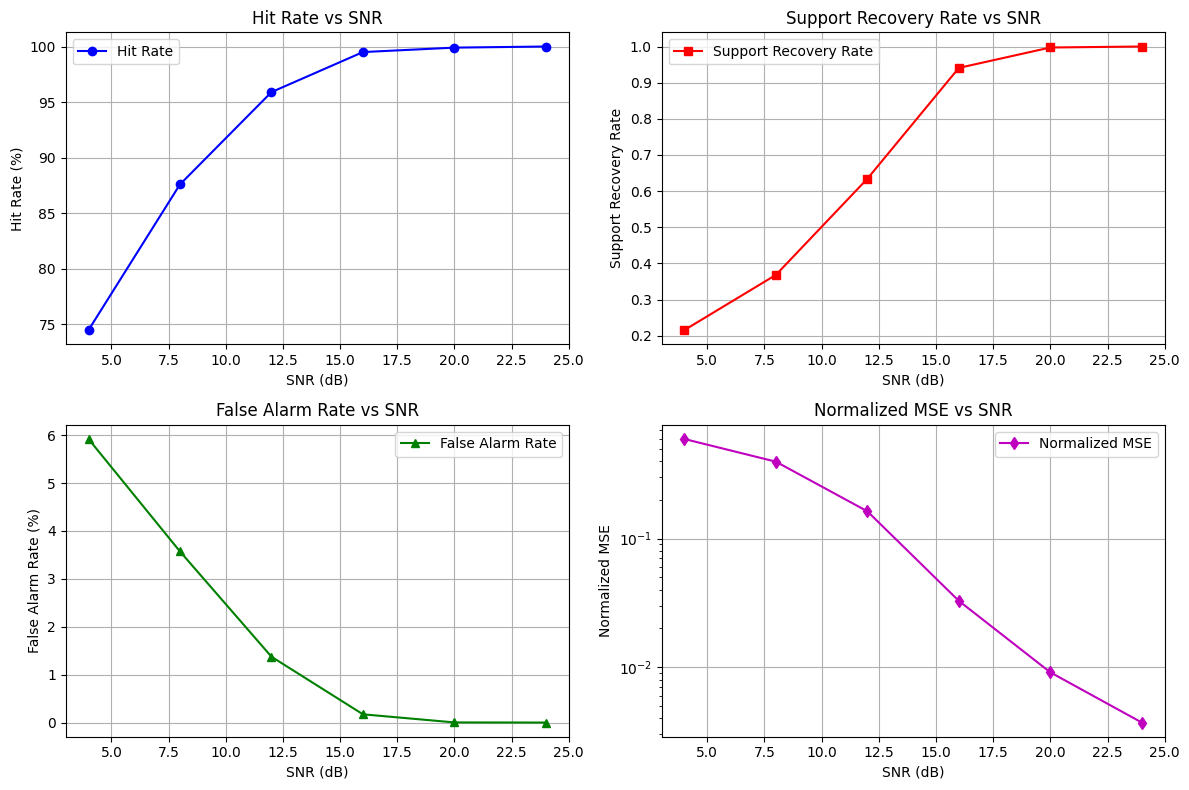

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(12, 8))

# Plot Hit Rate
plt.subplot(2, 2, 1)
plt.plot(snr_values, avg_hit_rate_casbl, marker='o', linestyle='-', color='b', label='Hit Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate
plt.subplot(2, 2, 2)
plt.plot(snr_values, avg_support_recovery_rate_casbl, marker='s', linestyle='-', color='r', label='Support Recovery Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate
plt.subplot(2, 2, 3)
plt.plot(snr_values, avg_false_alarm_rate_casbl, marker='^', linestyle='-', color='g', label='False Alarm Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE
plt.subplot(2, 2, 4)
plt.plot(snr_values, avg_norm_mse_casbl, marker='d', linestyle='-', color='m', label='Normalized MSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_casbl_vs_ground_truth(casbl_results, Z, sample_index, snr_index, snr_value):
    """Plot casbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # casbl Estimated Signal
    plt.plot(np.abs(casbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="casbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"casbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

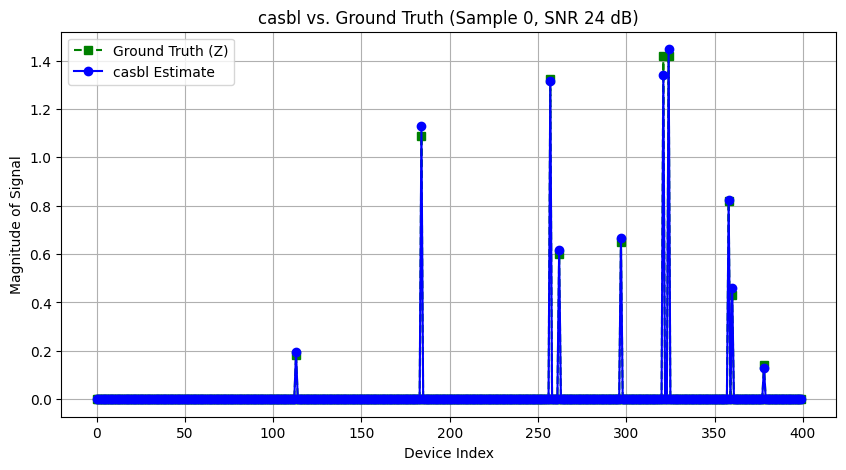

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_casbl_vs_ground_truth(z_casbl, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_casbl_vs_ground_truth(gamma_casbl, gamma_true, sample_index, snr_index, snr_value):
    """Plot casbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot casbl estimated gamma
    plt.stem(device_indices, gamma_casbl[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="casbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (casbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


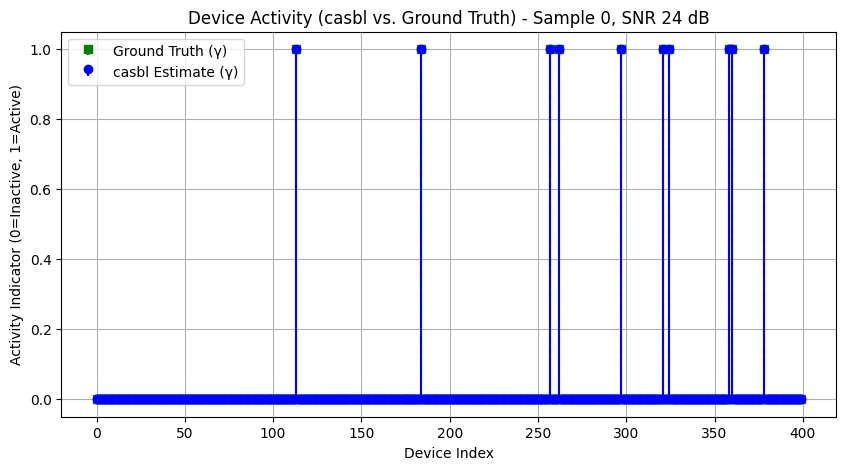

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_casbl_vs_ground_truth(gamma_casbl, all_gamma, sample_index, snr_index, snr_value)